<a href="https://colab.research.google.com/github/florinabas/Neural-Pathways-Analysis/blob/main/CSD_NetPyNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netpyne
!pip install neuron


Simulation complete. Plotting membrane potentials


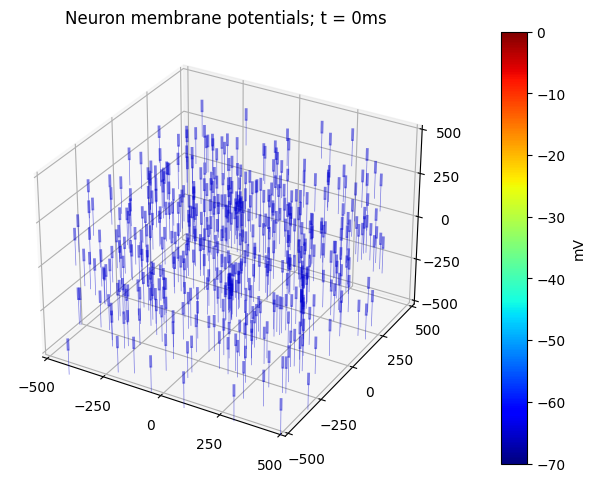

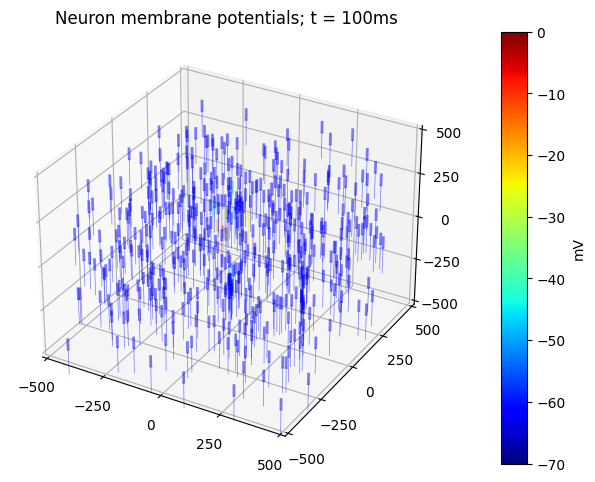

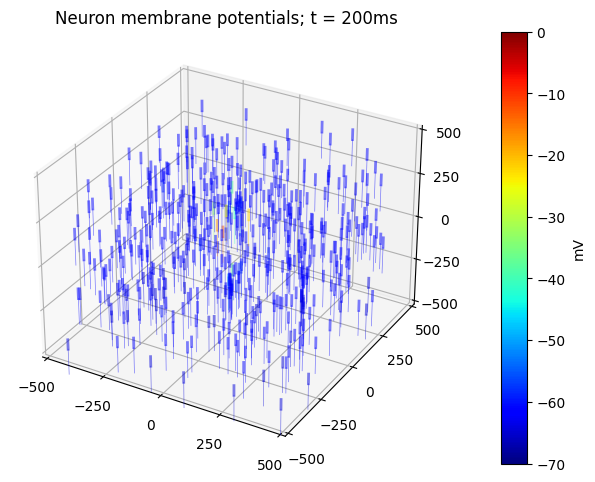

In [ ]:
from neuron import h, crxd as rxd
from neuron.crxd import rxdmath
from matplotlib import pyplot, colors, colorbar
from matplotlib_scalebar import scalebar
from mpl_toolkits.mplot3d import Axes3D
import numpy
import os
import sys
import pickle
#h.nrn_load_dll(".")  # in case compiling mod files fails

input=0 #0 for hh, 1 for more complex
tstop=200 #30000 in paper
h.celsius = 37

dir="."
outdir = os.path.abspath(dir)
plotdir="./plots"
h.load_file('stdrun.hoc')

#when using multiple processes get the relevant id
pc = h.ParallelContext()

rxd.options.enable.extracellular = True # enable extracellular rxd

# simulation parameters
Lx, Ly, Lz = 1000, 1000, 1000       # size of the extracellular space mu m^3
Kceil = 15.0                        # threshold used to determine wave speed
Ncell = int(10000*(Lx*Ly*Lz*1e-9))  # low neuron density: (10'000 per mm^3)
Nrec = 500
somaR = 28     # soma radius
dendR = 8      # dendrite radius
dendL = 150    # dendrite length
doff = dendL + somaR

# diffusion characteristics
alpha = 0.2  # normoxic constant for volume fraction
tort = 1.6   # normoxic constant for tortuositie
r0 = 100     # radius for initial elevated K+

# Option 0 - A neuron with soma and dendrite with HH mechanism.
# Option 1 - A neuron with soma and dendrite with fast and persistent Na and K currents, passive leak and K leak and an accumulation mechanism
class Neuron:

    def __init__(self, x, y, z, rec=False):
        self.x = x
        self.y = y
        self.z = z

        self.soma = h.Section(name='soma', cell=self)
        # add 3D points to locate the neuron in the ECS
        self.soma.pt3dadd(x, y, z + somaR, 2.0*somaR)
        self.soma.pt3dadd(x, y, z - somaR, 2.0*somaR)

        self.dend = h.Section(name='dend', cell=self)
        self.dend.pt3dadd(x, y, z - somaR, 2.0*dendR)
        self.dend.pt3dadd(x, y, z - somaR - dendL, 2.0*dendR)

        self.dend.connect(self.soma, 1,0)

        # insert the same mechanisms with the same parameters in both the soma
        # and the dendrite
        if input==0:
            for mechanism in ['hh']:
                self.soma.insert(mechanism)
                self.dend.insert(mechanism)
        else:
            for mechanism in ['tnak', 'tnap', 'taccumulation3', 'kleak']:
                self.soma.insert(mechanism)
                self.dend.insert(mechanism)

            ## the sodium/potassium pump is not used in this model
            self.soma(0.5).tnak.imax = 0
            self.dend(0.5).tnak.imax = 0

        if rec: # record membrane potential (shown in figure 1C)
            self.somaV = h.Vector()
            self.somaV.record(self.soma(0.5)._ref_v, rec)
            self.dendV = h.Vector()
            self.dendV.record(self.dend(0.5)._ref_v, rec)

# Randomly distribute 1000 neurons which we record the membrane potential every 100ms
rec_neurons = [Neuron(
    (numpy.random.random()*2.0 - 1.0) * (Lx/2.0 - somaR),
    (numpy.random.random()*2.0 - 1.0) * (Ly/2.0 - somaR),
    (numpy.random.random()*2.0 - 1.0) * (Lz/2.0 - somaR), 100)
    for i in range(0, Nrec)]

# Randomly distribute the remaining neurons
all_neurons = [Neuron(
    (numpy.random.random()*2.0 - 1.0) * (Lx/2.0 - somaR),
    (numpy.random.random()*2.0 - 1.0) * (Ly/2.0 - somaR),
    (numpy.random.random()*2.0 - 1.0) * (Lz/2.0 - somaR))
    for i in range(Nrec, Ncell)]

# Where? -- define the extracellular space
#DEMO USES LARGER VOXELS
ecs = rxd.Extracellular(-Lx/2.0, -Ly/2.0,
                        -Lz/2.0, Lx/2.0, Ly/2.0, Lz/2.0, dx=25,
                        volume_fraction=alpha, tortuosity=tort)


# What? -- define the species
k = rxd.Species(ecs, name='k', d=2.62, charge=1, initial=lambda nd: 40
                if nd.x3d**2 + nd.y3d**2 + nd.z3d**2 < r0**2 else 3.5,
                ecs_boundary_conditions=3.5)

na = rxd.Species(ecs, name='na', d=1.78, charge=1, initial=133.574,
                 ecs_boundary_conditions=133.574)

pc.set_maxstep(100) # required when using multiple processes


# initialize and set the intracellular concentrations
h.finitialize()
for sec in h.allsec():
    sec.nai = 4.297

# report progress of the simulation
def progress_bar(tstop, size=40):
    prog = h.t/float(tstop)
    fill = int(size*prog)
    empt = size - fill
    progress = '#' * fill + '-' * empt
    sys.stdout.write('[%s] %2.1f%% %6.1fms of %6.1fms\r' % (progress, 100*prog, pc.t(0), tstop))
    sys.stdout.flush()

# Plot a 2d image of the data
def plot_image_data(data, min_val, max_val, filename, title):
    sb = scalebar.ScaleBar(1e-6)
    sb.location='lower left'
    pyplot.imshow(data, extent=k[ecs].extent('xy'), vmin=min_val,
                  vmax=max_val, interpolation='nearest', origin='lower')
    pyplot.colorbar()
    sb = scalebar.ScaleBar(1e-6)
    sb.location='lower left'
    ax = pyplot.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.add_artist(sb)
    pyplot.title(title)
    pyplot.xlim(k[ecs].extent('x'))
    pyplot.ylim(k[ecs].extent('y'))
    pyplot.close()


h.dt = 10  # use a large time step as we are not focusing on spiking behaviour but on slower diffusion

#Run the simulations saving figures every 100ms and recording the wave progression every time step
while pc.t(0) < tstop:
    if int(pc.t(0)) % 100 == 0:
        # plot extracellular concentrations averaged over depth every 100ms
        plot_image_data(k[ecs].states3d.mean(2), 3.5, 40,
                        'k_mean_%05d' % int(pc.t(0)/100),
                        'Potassium concentration; t = %6.0fms'
                        % pc.t(0))

    progress_bar(tstop)
    pc.psolve(pc.t(0)+h.dt)  # run the simulation for 1 time step

progress_bar(tstop)
print("\nSimulation complete. Plotting membrane potentials")

# save membrane potentials
soma, dend, pos = [], [], []
somaV, dendV, pos = [], [], []
for n in rec_neurons:
    soma.append(n.somaV)
    dend.append(n.dendV)
    pos.append([n.x,n.y,n.z])


[sV, dV, p]=[soma,dend,pos]
somaV.extend(sV)
dendV.extend(dV)
pos.extend(p)

for idx in range(somaV[0].size()):
     # create a plot for each record (100ms)

     fig = pyplot.figure()
     ax = fig.add_subplot(111,projection='3d')
     ax.set_position([0.0,0.05,0.9,0.9])
     ax.set_xlim([-Lx/2.0, Lx/2.0])
     ax.set_ylim([-Ly/2.0, Ly/2.0])
     ax.set_zlim([-Lz/2.0, Lz/2.0])
     ax.set_xticks([int(Lx*i/4.0) for i in range(-2,3)])
     ax.set_yticks([int(Ly*i/4.0) for i in range(-2,3)])
     ax.set_zticks([int(Lz*i/4.0) for i in range(-2,3)])

     cmap = pyplot.get_cmap('jet')
     for i in range(Nrec):
         x = pos[i]
         soma_z = [x[2]-somaR,x[2]+somaR]
         cell_x = [x[0],x[0]]
         cell_y = [x[1],x[1]]
         scolor = cmap((somaV[i].get(idx)+70.0)/70.0)
         # plot the soma
         ax.plot(cell_x, cell_y, soma_z, linewidth=2, color=scolor,
                 alpha=0.5)

         dcolor = cmap((dendV[i].get(idx)+70.0)/70.0)
         dend_z = [x[2]-somaR, x[2]-somaR - dendL]
         # plot the dendrite
         ax.plot(cell_x, cell_y, dend_z, linewidth=0.5, color=dcolor,
                 alpha=0.5)

     norm = colors.Normalize(vmin=-70,vmax=0)
     pyplot.title('Neuron membrane potentials; t = %gms' % (idx * 100))

     # add a colorbar
     ax1 = fig.add_axes([0.88,0.05,0.04,0.9])
     cb1 = colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm,
                                         orientation='vertical')
     cb1.set_label('mV')


In [ ]:
from netpyne import specs, sim

# # Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters
## Cell Parameters
# L soma? & Ra?
secs = {}  # cell rule dict
secs['soma'] = {'geom': {}, 'mechs': {}}
secs['soma']['geom'] = {'diam': 56, 'L': 18.8, 'Ra': 123.0}
secs['soma']['mechs']['hh'] = {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -70}

#Ra?
secs['dend'] = {'geom': {}, 'mechs': {}}
secs['dend']['geom'] = {'diam': 16, 'L': 150, 'Ra': 123.0}
secs['dend']['mechs']['hh'] = {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -70}

netParams.cellParams['PYR'] = {'secs': secs}

#------------------------------------------------------------------------------
## Population parameters
netParams.popParams['all'] = {'cellType': 'PYR', 'numCells': 9500}
netParams.popParams['rec'] = {'cellType': 'PYR', 'numCells': 500}

## RxD params

### Where?
### regions
regions = {}
regions['ecs'] = {'xlo':-100, 'ylo':-100, 'zlo':-100,
                'xhi':100, 'yhi':100, 'zhi':100, 'volume_fraction':0.2,'tortuosity': 1.6}

netParams.rxdParams['regions'] = regions

### What? -- define the species
species = {}
species['na'] = {'regions': ['ecs'], 'd': 1.78, 'charge':1, 'initial': 133.574}

species['k'] = {'regions': ['ecs'], 'd': 2.62, 'charge': 1,
               'initial': '40 if node.x3d**2 + node.y3d**2 + node.z3d**2 < 100**2 else 3.5'}

netParams.rxdParams['species'] = species


# SIMULATION CONFIGURATION

# Simulation options
simConfig = specs.SimConfig() # object of class SimConfig to store simulation configuration

simConfig.duration = 2                     # Duration of the simulation, in ms
simConfig.dt = 1                           # Internal integration timestep to use
simConfig.verbose = False                       # Show detailed messages
simConfig.recordTraces = {'V_soma': {'sec':'soma','loc':0.5, 'var':'v'}}  # Dict with traces to record
simConfig.recordStep = 0.1                      # Step size in ms to save data (e.g. V traces, LFP, etc)
simConfig.filename = 'model_output'             # Set file output name
simConfig.savePickle = False                    # Save params, network and sim output to pickle file

simConfig.analysis['plotTraces'] = {'include': [1, 21, 41, 61, 81]} # Plot recorded traces for this list of cells
simConfig.analysis['plotRaster'] = {'orderInverse': True, 'syncLines': True}  # Plot a raster
simConfig.analysis['plotSpikeHist'] = {'include': ['rec']}                 # Plot spike histogram


# create, simualte and analyze model
sim.createSimulateAnalyze(netParams, simConfig)


Start time:  2023-08-19 08:52:46.930477

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 10000 
  Done; cell creation time = 4.51 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.03 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Adding RxD...
  Created Region ecs
  Created Species na
  Created Species k
  Done; RxD setup time = 0.01 s.


KeyboardInterrupt: ignored

Recording 5 traces of 1 types on node 0

Running simulation using NEURON for 2.0 ms...
  Done; run time = 50.48 s; real-time ratio: 0.00.

Gathering data...
  Done; gather time = 1.14 s.

Analyzing...
  Cells: 10000
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.0 s; 1 workers
  Run time: 50.48 s
Plotting recorded cell traces ... cell
Preparing spike data...
No spikes available to plot raster
Plotting raster...
  There was an exception in plotRaster(): 
    local variable 'spkInds' referenced before assignment 
    (<class 'UnboundLocalError'>, UnboundLocalError("local variable 'spkInds' referenced before assignment"), <traceback object at 0x7f1736f34080>)
Preparing spike data...
No spikes available to plot raster
  There was an exception in prepareSpikeHist(): 
    'NoneType' object is not subscriptable 
    (<class 'TypeError'>, TypeError("'NoneType' object is not subscriptable"), <traceback object at 0x7f1736dd0ec0>)
Plotting spike histogram...
  There wa